## Wine Classification

#### Alex Bear - 16/04/2019

In [1]:
# Import packages
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling
import os
import seaborn as sns
import shutil
import sklearn
import wget

from IPython.display import display, clear_output
from sklearn.model_selection import train_test_split


from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Download read wine dataset
output = 'red_wine.csv'
file = wget.download('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', output)
# Overwrite file if already exists
if os.path.exists(output):
    shutil.move(file,output)

# Download white wine dataset
output = 'white_wine.csv'
file = wget.download('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv', output)
# Overwrite file if already exists
if os.path.exists(output):
    shutil.move(file,output)

100% [............................................................................] 264426 / 264426

In [3]:
# Read in red and white wine datasets
df_red = pd.read_csv('red_wine.csv', sep=';')
df_white = pd.read_csv('white_wine.csv', sep=';')

In [4]:
# Description of red wine df
df_red.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [5]:
# Description of white wine df
df_white.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


## Intial data considerations - first thoughts


May have issues with the target variable where while the rating is supposed to range between 0 and 10 the data only includes quality values from 3 to 8 for red and to 9 for white - ordinal regression or classifiaction could be considered. Meanwhile the std is comparatively quite low at 0.89 (closely centred to the mean of 5.88) which may limit gaining value from the the target variable. The min of `citric_acid` of 0 stands out as an intial potential error to investigate, whether 0 value is over represented - either way outlier detection methods will be used in tangent with feature selection methods to test importance of supporting variables. 

Otherwise the data overall seems (at least initially) very clean. Next step is to dive into the investigation of the data including looking at the spread of the data. Seeing as we are coming into the winter and I prefer a red in the cold I will just focus on red wine for now.

At this stage I'm not too sure what will work better in the battle of regression vs. classification. Let's give both a go and see how they work out.

:)

In [6]:
# Focus of red wine
df = df_red
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed_acidity           1599 non-null float64
volatile_acidity        1599 non-null float64
citric_acid             1599 non-null float64
residual_sugar          1599 non-null float64
chlorides               1599 non-null float64
free_sulfur_dioxide     1599 non-null float64
total_sulfur_dioxide    1599 non-null float64
density                 1599 non-null float64
ph                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [8]:
# Percentage of 0 values in citric acid
df.loc[df['citric_acid'] == 0].count()[0]/df.count()[0]*100

8.25515947467167

A percentage of 8.26% of 0 values for `citric_acid` is not considerable/ does not appear to be an issue

In [9]:
# Percentage of most frequent variable value
for i in df.columns:
    print('\033[1m'+i+':'+'\033[0m',"{:.2%}".format((lambda x: x.value_counts().max() / len(df))(df[i])))

fixed_acidity: 4.19%
volatile_acidity: 2.94%
citric_acid: 8.26%
residual_sugar: 9.76%
chlorides: 4.13%
free_sulfur_dioxide: 8.63%
total_sulfur_dioxide: 2.69%
density: 2.25%
ph: 3.56%
sulphates: 4.32%
alcohol: 8.69%
quality: 42.59%


Constant values do not appear to be an issue either aside from perhaps `quality` variable

Dropdown(description='Select variable:', options=('fixed_acidity', 'volatile_acidity', 'citric_acid', 'residua…

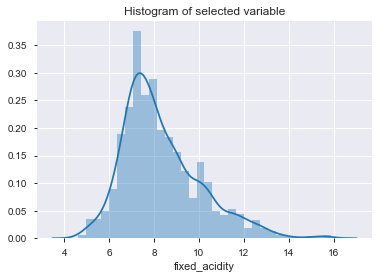

In [10]:
# Histograms of each variable
x = widgets.Dropdown(options=df.columns,value='fixed_acidity',description='Select variable:',disabled=False)

def plothist(i):
    clear_output()
    display(x)
    sns.distplot(df[[x.value]].squeeze())
    plt.title("Histogram of selected variable")
    plt.show()

plothist('i')
x.observe(plothist, names='value')

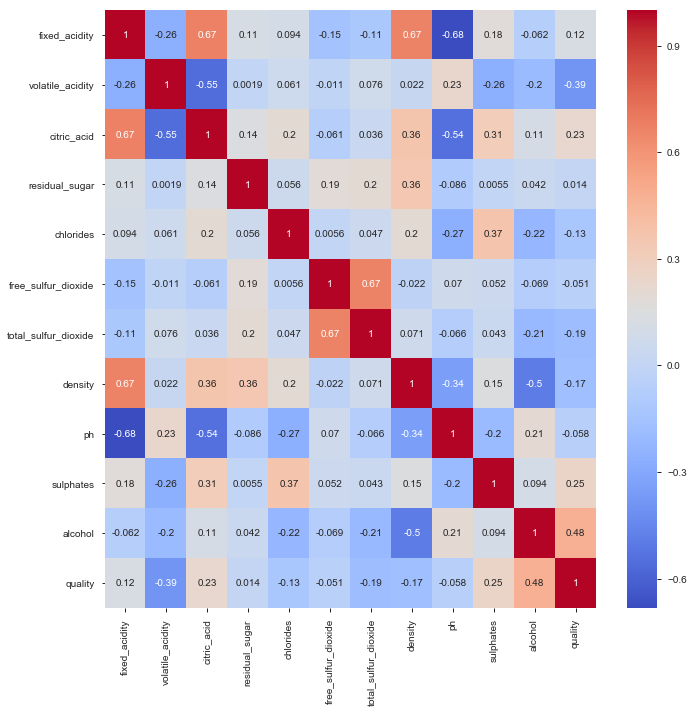

In [11]:
# Correlation matrix of red wine variables
plt.figure(figsize=(11,11))
sns.heatmap(df.corr(),annot=True, cmap='coolwarm')
plt.show()

Dropdown(description='Select variable:', options=('fixed_acidity', 'volatile_acidity', 'citric_acid', 'residua…

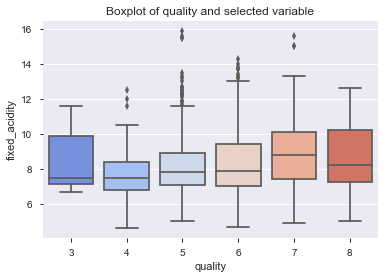

In [12]:
# Value distribution of quality
y = widgets.Dropdown(options=df.drop(columns='quality').columns,value='fixed_acidity',description='Select variable:',disabled=False)

def plotboxplot(i):
    clear_output()
    display(y)
    sns.boxplot(x="quality",y=y.value,data=df,palette="coolwarm")
    plt.title("Boxplot of quality and selected variable")
    plt.show()

plotboxplot('i')
y.observe(plotboxplot, names='value')

In [14]:
# Checking out pandas profiling
df.profile_report()

### Train and test sets

Ideally we would do this split earlier to avoid bias, regardless so far we have had a happy and healthy looking baby!

In [15]:
from sklearn.preprocessing import Normalizer

In [34]:
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,:11].values, df.iloc[:,-1].values, test_size=0.2)

In [35]:
x_train = Normalizer().fit_transform(x_train)
x_test = Normalizer().fit_transform(x_test)

#x_train = StandardScaler().fit_transform(x_train)
#x_test = StandardScaler().fit_transform(x_test)

In [39]:
help(DecisionTreeClassifier())

Help on DecisionTreeClassifier in module sklearn.tree.tree object:

class DecisionTreeClassifier(BaseDecisionTree, sklearn.base.ClassifierMixin)
 |  DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort=False)
 |  
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : string, optional (default="gini")
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : string, optional (default="best")
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choose
 |      the best random split

In [36]:
dtc = DecisionTreeClassifier().fit(x_train, y_train)

In [37]:
#from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [38]:
cross_val_score(dtc, x_train, y_train, cv=10)

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


array([0.61068702, 0.64122137, 0.56153846, 0.5503876 , 0.58914729,
       0.51181102, 0.63492063, 0.6031746 , 0.616     , 0.576     ])

In [30]:
#accuracy_score(y_test,dtc.predict(x_test))

In [22]:
from sklearn.tree import DecisionTreeClassifier

In [23]:
DecisionTreeClassifier.fit(df_train)


NameError: name 'df_train' is not defined

In [ ]:
df.columns

In [ ]:
from sklearn import m

In [ ]:
#exploration insights

In [ ]:
#show distribution

In [ ]:
#show importance plots

In [ ]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()